In [1]:
import IPython
import sys
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from music21 import *
from grammar import *
from qa import *
from preprocess import * 
from music_utils import *
from data_utils import *
from outputs import *
from test_utils import *

from tensorflow.keras.layers import Dense, Activation, Dropout, Input, LSTM, Reshape, Lambda, RepeatVector
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

The preprocessing of the musical data has been taken care of already, which for this notebook means it's been rendered in terms of musical "values." 

#### What are musical "values"? 
You can informally think of each "value" as a note, which comprises a pitch and duration. For example, if you press down a specific piano key for 0.5 seconds, then you have just played a note. In music theory, a "value" is actually more complicated than this -- specifically, it also captures the information needed to play multiple notes at the same time. For example, when playing a music piece, you might press down two piano keys at the same time (playing multiple notes at the same time generates what's called a "chord"). But you don't need to worry about the details of music theory for this assignment.

In [4]:
X, Y, n_values, indices_values, chords = load_music_utils('data/original_metheny.mid')
print('number of training examples:', X.shape[0])
print('Tx (length of sequence):', X.shape[1])
print('total # of unique values:', n_values)
print('shape of X:', X.shape)
print('Shape of Y:', Y.shape)
print('Number of chords', len(chords))

number of training examples: 60
Tx (length of sequence): 30
total # of unique values: 90
shape of X: (60, 30, 90)
Shape of Y: (30, 60, 90)
Number of chords 19


<a name='1-2'></a>
### 1.2 - Model Overview

Here is the architecture of the model you'll use. It's similar to the Dinosaurus model, except that you'll implement it in Keras.

<img src="images/music_generation.png" style="width:600;height:400px;">
<caption><center><font color='purple'><b>Figure </b>: Basic LSTM model </center></caption>


* $X = (x^{\langle 1 \rangle}, x^{\langle 2 \rangle}, \cdots, x^{\langle T_x \rangle})$ is a window of size $T_x$ scanned over the musical corpus. 
* Each $x^{\langle t \rangle}$ is an index corresponding to a value.
* $\hat{y}^{\langle t \rangle}$ is the prediction for the next value.
* You'll be training the model on random snippets of 30 values taken from a much longer piece of music. 
    - Thus, you won't bother to set the first input $x^{\langle 1 \rangle} = \vec{0}$, since most of these snippets of audio start somewhere in the middle of a piece of music. 
    - You're setting each of the snippets to have the same length $T_x = 30$ to make vectorization easier.

In [5]:
# number of dimensions for the hidden state of each LSTM cell.
n_a = 64 

In [6]:
n_values = 90 # number of music values
reshaper = Reshape((1, n_values))                  # Used in Step 2.B of djmodel(), below
LSTM_cell = LSTM(n_a, return_state = True)         # Used in Step 2.C
densor = Dense(n_values, activation='softmax')     # Used in Step 2.D

In [7]:
def djmodel(Tx, LSTM_cell, densor, reshaper):
    """
    Implement the djmodel composed of Tx LSTM cells where each cell is responsible
    for learning the following note based on the previous note and context.
    Each cell has the following schema: 
            [X_{t}, a_{t-1}, c0_{t-1}] -> RESHAPE() -> LSTM() -> DENSE()
    Arguments:
        Tx -- length of the sequences in the corpus
        LSTM_cell -- LSTM layer instance
        densor -- Dense layer instance
        reshaper -- Reshape layer instance
    
    Returns:
        model -- a keras instance model with inputs [X, a0, c0]
    """
    
    n_values = densor.units               # Get the shape of input values
    n_a = LSTM_cell.units                 # Get the number of the hidden state vector
    X = Input(shape=(Tx, n_values))       # Define the input layer and specify the shape
    
    # Define the initial hidden state a0 and initial cell state
    a0 = Input(shape=(n_a,), name='a0')
    c0 = Input(shape=(n_a,), name='c0')
    a = a0
    c = c0
    
    outputs = []
    
    
    for t in range(Tx):
        
        # Select the "t"th time step vector from X. 
        x = X[:,t,:]
        x = reshaper(x)
        a, _, c = LSTM_cell(inputs = x, initial_state=[a, c])
        out = densor(a)
        outputs.append(out)
        
    # Create model instance
    model = Model(inputs=[X, a0, c0], outputs=outputs)
    
    return model

In [8]:
model = djmodel(Tx=30, LSTM_cell=LSTM_cell, densor=densor, reshaper=reshaper)

In [9]:
# UNIT TEST
output = summary(model) 
comparator(output, djmodel_out)

All tests passed!


In [10]:
# Check your model
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 30, 90)]     0                                            
__________________________________________________________________________________________________
tf_op_layer_strided_slice (Tens [(None, 90)]         0           input_1[0][0]                    
__________________________________________________________________________________________________
reshape (Reshape)               (None, 1, 90)        0           tf_op_layer_strided_slice[0][0]  
                                                                 tf_op_layer_strided_slice_1[0][0]
                                                                 tf_op_layer_strided_slice_2[0][0]
                                                                 tf_op_layer_strided_sl

In [11]:
opt = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, decay=0.01)

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
m = 60
a0 = np.zeros((m, n_a))
c0 = np.zeros((m, n_a))

In [19]:
history = model.fit([X, a0, c0], list(Y), epochs=100, verbose = 0)

loss at epoch 1: 129.9491424560547
loss at epoch 100: 10.240907669067383


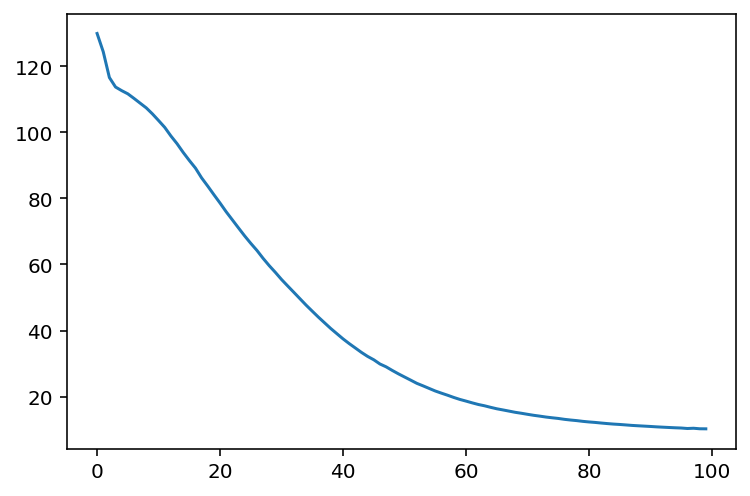

In [20]:
print(f"loss at epoch 1: {history.history['loss'][0]}")
print(f"loss at epoch 100: {history.history['loss'][99]}")
plt.plot(history.history['loss'])

<a name='3'></a>
## Generating Music

You now have a trained model which has learned the patterns of a jazz soloist. You can now use this model to synthesize new music! 

<a name='3-1'></a>
### Predicting & Sampling

<img src="images/music_gen.png" style="width:600;height:400px;">
<center><caption><b><font color='purple'>Figure : Generating new values in an LSTM </b></font>

In [36]:
def music_inference_model(LSTM_cell, densor, Ty=100):
    """
    Uses the trained "LSTM_cell" and "densor" from model() to generate a sequence of values.
    
    Arguments:
    LSTM_cell -- the trained "LSTM_cell" from model(), Keras layer object
    densor -- the trained "densor" from model(), Keras layer object
    Ty -- integer, number of time steps to generate
    
    Returns:
    inference_model -- Keras model instance
    """

    n_values = densor.units               # Get the shape of input values
    n_a = LSTM_cell.units                 # Get the number of the hidden state vector
    x0 = Input(shape=(1, n_values))       # Define the input of your model with a shape 
    
    
    # Define s0, initial hidden state for the decoder LSTM
    a0 = Input(shape=(n_a,), name='a0')
    c0 = Input(shape=(n_a,), name='c0')
    a = a0
    c = c0
    x = x0

    
    # Create an empty list of "outputs" to later store your predicted values
    outputs = []
    
    # Loop over Ty and generate a value at every time step
    for t in range(Ty):
        a, _, c = LSTM_cell(x, initial_state=[a, c])
        out = densor(a)
        outputs.append(out)
        
        x = tf.math.argmax(out, axis = -1)
        x = tf.one_hot(x,n_values)
        x = RepeatVector(1)(x)
        
    # Create model instance with the correct "inputs" and "outputs"
    inference_model = Model(inputs=[x0, a0, c0], outputs=outputs)
    
    return inference_model

Run the cell below to define your inference model. This model is hard coded to generate 50 values.

In [37]:
inference_model = music_inference_model(LSTM_cell, densor, Ty = 50)

In [38]:
# UNIT TEST
inference_summary = summary(inference_model) 
comparator(inference_summary, music_inference_model_out)

All tests passed!


In [39]:
# Check the inference model
inference_model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 1, 90)]      0                                            
__________________________________________________________________________________________________
a0 (InputLayer)                 [(None, 64)]         0                                            
__________________________________________________________________________________________________
c0 (InputLayer)                 [(None, 64)]         0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 64), (None,  39680       input_9[0][0]                    
                                                                 a0[0][0]              

In [40]:
x_initializer = np.zeros((1, 1, n_values))
a_initializer = np.zeros((1, n_a))
c_initializer = np.zeros((1, n_a))

In [54]:
def predict_and_sample(inference_model, x_initializer = x_initializer, a_initializer = a_initializer, 
                       c_initializer = c_initializer):
    """
    Predicts the next value of values using the inference model.
    
    Arguments:
    inference_model -- Keras model instance for inference time
    x_initializer -- numpy array of shape (1, 1, 90), one-hot vector initializing the values generation
    a_initializer -- numpy array of shape (1, n_a), initializing the hidden state of the LSTM_cell
    c_initializer -- numpy array of shape (1, n_a), initializing the cell state of the LSTM_cel
    
    Returns:
    results -- numpy-array of shape (Ty, 90), matrix of one-hot vectors representing the values generated
    indices -- numpy-array of shape (Ty, 1), matrix of indices representing the values generated
    """
    
    n_values = x_initializer.shape[2]
    
    # Use the inference model to predict an output sequence given x_initializer, a_initializer and c_initializer.
    pred = inference_model.predict([x_initializer, a_initializer, c_initializer])
    # Convert "pred" into an np.array() of indices with the maximum probabilities
    indices = np.argmax(pred,axis = -1)
    # Convert indices to one-hot vectors
    results = to_categorical(indices, num_classes=n_values)
    
    return results, indices

In [55]:
results, indices = predict_and_sample(inference_model, x_initializer, a_initializer, c_initializer)

print("np.argmax(results[12]) =", np.argmax(results[12]))
print("np.argmax(results[17]) =", np.argmax(results[17]))
print("list(indices[12:18]) =", list(indices[12:18]))

np.argmax(results[12]) = 2
np.argmax(results[17]) = 10
list(indices[12:18]) = [array([2]), array([51]), array([7]), array([51]), array([47]), array([10])]


In [56]:
out_stream = generate_music(inference_model, indices_values, chords)

Predicting new values for different set of chords.
Generated 36 sounds using the predicted values for the set of chords ("1") and after pruning
Generated 36 sounds using the predicted values for the set of chords ("2") and after pruning
Generated 36 sounds using the predicted values for the set of chords ("3") and after pruning
Generated 36 sounds using the predicted values for the set of chords ("4") and after pruning
Generated 36 sounds using the predicted values for the set of chords ("5") and after pruning
Your generated music is saved in output/my_music.midi


<a name='4'></a>
## References

The ideas presented in this notebook came primarily from three computational music papers cited below. The implementation here also took significant inspiration and used many components from Ji-Sung Kim's GitHub repository.

- Ji-Sung Kim, 2016, [deepjazz](https://github.com/jisungk/deepjazz)
- Jon Gillick, Kevin Tang and Robert Keller, 2009. [Learning Jazz Grammars](http://ai.stanford.edu/~kdtang/papers/smc09-jazzgrammar.pdf)
- Robert Keller and David Morrison, 2007, [A Grammatical Approach to Automatic Improvisation](http://smc07.uoa.gr/SMC07%20Proceedings/SMC07%20Paper%2055.pdf)
- François Pachet, 1999, [Surprising Harmonies](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.5.7473&rep=rep1&type=pdf)

Finally, a shoutout to François Germain for valuable feedback.